In [1]:
#Imports & db connection setup
from modules.preamble import *
from modules.event_data_conversion import get_time_between_events, events_to_rt_pred

#Enter information to access your PostgreSQL MIMIC database from Python
con = psycopg2.connect(dbname='mimic', user='postgres', password='postgres', port=5433) #Your credentials for the database connector
query_schema = 'set search_path to mimiciii;' #Your search path to the MIMIC-III schema

%matplotlib inline

C:\Users\s113277\.conda\envs\base2\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\s113277\.conda\envs\base2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\s113277\.conda\envs\base2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\s113277\.conda\envs\base2\lib\site-packages\tensorflow\python\frame

# Loading & processing data
Including some preliminary cleaning & merging.

## Events

In [2]:
#Load datasets from the "Event Tables Filtering" notebook
df_bm = pd.read_hdf(os.path.join(data_base_path, "cleaned_BM_events.hdf"));
df_lt = pd.read_hdf(os.path.join(data_base_path, "cleaned_LT_events.hdf"));

In [3]:
#Drop the at3 variable because it was only measured 4 times in total
df_lt = df_lt[~(df_lt['variable']=='at3')]

In [4]:
#Drop all events with valuenum = NaN. They cannot be used anyway
df_bm = df_bm[~df_bm['valuenum'].isnull()]
df_lt = df_lt[~df_lt['valuenum'].isnull()]

In [5]:
#Concatenate all events into a single dataframe
df = pd.concat([df_bm, df_lt]).reset_index(drop=True)

# Conversion to modeling format
According to strategy (3), which resulted in the best features (as we have previously determined).

In [6]:
#Note that splitting prior to this is not necessary, because we do not need to estimate the time between events
df_mod = events_to_rt_pred(df = df[['subject_id', 'charttime', 'variable', 'valuenum']],
                           max_cft = pd.Timedelta('200y')) #Very long max carry-forward time to simulate full forward filling

Add the target label: mortality in 72hrs.

In [7]:
def extract_TOD(database_connection):
    """
    Extracts table with the times of death of the septic shock patients. 
    Returns the result as a dataframe.
    
    inputs
    -----
    database_connection: database connection to the MIMIC-III PostgreSQL database.
    """
    
    qry = query_schema + """ 
        WITH ss_patients AS (
            SELECT *
            FROM explicit_sepsis
            WHERE septic_shock=1
        )
        
        SELECT
            a.subject_id, max(a.deathtime) as deathtime
        FROM
            admissions AS a 
            INNER JOIN
                ss_patients AS ssp 
                    ON 
                        a.subject_id = ssp.subject_id 
                        AND
                        a.hadm_id = ssp.hadm_id
        GROUP BY a.subject_id
        ORDER BY a.subject_id
        
    """
    df = pd.read_sql(qry, database_connection, parse_dates = 'deathtime')
    return df

In [8]:
df_tod = extract_TOD(con)

df_mod = df_mod.merge(df_tod, on='subject_id', how='left')
df_mod['time to death'] = df_mod['deathtime'] - df_mod['charttime']

    #Add the label we are interested in: mortality within 72h
df_mod['y'] = (df_mod['time to death'] <= pd.Timedelta('72 hours')).astype(int).values

# Split
Split data according to the two strategies.

In [11]:
#Observation-based splitting
from sklearn.model_selection import train_test_split

random_state=10

#Select all subjects
all_subjects = df_mod['subject_id'].unique()

#Make a split among subjects, stratified on the target label
df_train_obs, df_test_obs = train_test_split(
    df_mod,
    test_size=0.3,
    random_state=random_state)

#Short check: are most patients in both sets?
print("Number of patients in train & test sets:", df_train_obs['subject_id'].nunique(), df_test_obs['subject_id'].nunique())
print("Events in train & test sets:", len(df_train_obs), len(df_test_obs))
print('Fraction of instances in class y=1 in both datasets:', df_train_obs['y'].mean(), df_test_obs['y'].mean())

Number of patients in train & test sets: 2416 2414
Events in train & test sets: 647390 277453
Fraction of instances in class y=1 in both datasets: 0.09969415653624554 0.09958443412037354


In [12]:
#Patient-based/case-based splitting

from sklearn.model_selection import train_test_split

random_state=10 #Trial & error with random state such that we get approximately 70% of events in training & 30% in testing

#Select all subjects
all_subjects = df_mod['subject_id'].unique()

#Make a split among subjects, stratified on the target label
train_subj, test_subj = train_test_split(
    all_subjects,
    test_size=0.3,
    random_state=random_state)

#Split the instances for modeling based on the subjects
df_train_case, df_test_case = [df_mod[df_mod['subject_id'].isin(train_subj)], df_mod[df_mod['subject_id'].isin(test_subj)]]

#Check if split conforms to requirements
print("Number of patients in train & test sets:", len(train_subj), len(test_subj))
print("Events in train & test sets:", len(df_train_case), len(df_test_case))
print("% of total events in train & test sets",
      len(df_train_case)/len(df_mod)*100,
      len(df_test_case)/len(df_mod)*100)
print('Fraction of instances in class y=1 in both datasets:', df_train_case['y'].mean(), df_test_case['y'].mean())

Number of patients in train & test sets: 1691 725
Events in train & test sets: 627862 296981
% of total events in train & test sets 67.88849566899464 32.11150433100537
Fraction of instances in class y=1 in both datasets: 0.10086770659794668 0.09711058956633589


# Still-missing values imputation with mean & normalization
Perform mean imputation & normalization, using means & stds from trainign sets to avoid leakage of the training data in the testing data!

In [13]:
feat_colnames = df_train_obs.iloc[:,2:-3].columns #Store feature column names

#Retrieve means & stds of the training sets
means_obs = df_train_obs[feat_colnames].mean()
stds_obs = df_train_obs[feat_colnames].std()
means_case = df_train_case[feat_colnames].mean()
stds_case = df_train_case[feat_colnames].std()

#Impute & normalize using the means & stds
for feat_colname in feat_colnames:
    df_train_obs[feat_colname] = df_train_obs[feat_colname].fillna(means_obs[feat_colname]).values
    df_train_obs[feat_colname] = (df_train_obs[feat_colname].values - means_obs[feat_colname]) / stds_obs[feat_colname]
    df_test_obs[feat_colname] = df_test_obs[feat_colname].fillna(means_obs[feat_colname]).values
    df_test_obs[feat_colname] = (df_test_obs[feat_colname].values - means_obs[feat_colname]) / stds_obs[feat_colname]
    
    df_train_case[feat_colname] = df_train_case[feat_colname].fillna(means_case[feat_colname]).values
    df_train_case[feat_colname] = (df_train_case[feat_colname].values - means_case[feat_colname]) / stds_case[feat_colname]
    df_test_case[feat_colname] = df_test_case[feat_colname].fillna(means_case[feat_colname]).values
    df_test_case[feat_colname] = (df_test_case[feat_colname].values - means_case[feat_colname]) / stds_case[feat_colname]

C:\Users\s113277\.conda\envs\base2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\s113277\.conda\envs\base2\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\s113277\.conda\envs\base2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

A few quick checks because of the warnings: did the normalization succeed?

In [14]:
df_train_obs

,subject_id,charttime,arterial base excess,arterial pco2,arterial ph,arterial po2,bicarbonate,bilirubin,calcium,creatinine,crp,cvp,diastolic blood pressure,fio2,glucose,got(asat),gpt(alat),heart rate,hematocrit,platelets,potassium,ptt,sodium,spo2,systolic blood pressure,temperature,urea,white blood cells,deathtime,time to death,y
135023,10377,2131-12-23 19:00:00,0.188372,0.597836,-0.205999,-0.549842,0.629220,-0.430809,-0.389304,-0.838853,0.000000,-0.252771,-0.442134,-0.588965,0.601435,-0.158978,-0.202838,-0.113723,-0.505832,-0.295747,-0.333380,0.387970,-1.023281,-0.833453,-1.037368,0.994027,-0.724301,-0.742599,NaT,NaT,0
153693,10742,2163-05-29 13:00:00,-0.793118,-1.265788,0.408433,-0.568876,-0.646132,-0.379024,0.896977,-0.531416,-0.728984,0.000000,1.193393,2.876887,0.350610,-0.172921,-0.233573,-1.585730,-0.414179,1.100411,-1.001643,-0.648990,0.705058,0.550447,1.626050,-0.474769,-0.373960,0.765616,NaT,NaT,0
744686,76078,2155-06-12 09:00:00,0.000000,0.000000,0.000000,0.000000,-0.646132,-0.344502,-1.207847,-0.039516,0.000000,0.000000,0.240289,-0.877786,0.655183,0.109036,-0.172103,-0.862870,-0.734966,3.425235,-1.168708,-0.059919,-1.791431,0.089147,-0.181269,0.526682,1.611301,0.808708,NaT,NaT,0
920493,99383,2131-06-06 14:38:00,-0.956700,-0.536544,-0.697545,-0.511774,-0.760003,2.572666,0.863567,0.267921,0.000000,0.000000,0.030606,-0.011323,-0.076815,0.115233,-0.159808,0.937711,-1.353627,-0.921175,2.411271,-0.059919,-1.379922,-0.141503,-0.228830,0.860498,-0.398985,4.051369,NaT,NaT,0
147908,10694,2153-08-17 18:07:00,-0.956700,-1.508869,0.531320,-1.101835,-0.646132,-0.430809,0.546173,0.759821,0.000000,0.000000,1.174331,0.566319,-0.133123,-0.183766,-0.230500,-0.253914,-0.253785,-0.428414,-1.669905,-0.556492,0.320982,0.319797,-1.132490,0.072691,2.020032,0.183876,2153-08-27 15:35:00,9 days 21:28:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617841,55639,2153-08-24 08:23:00,-0.793118,-1.427842,0.654206,-0.169157,-0.964971,-0.068320,-0.506239,-0.039516,0.000000,0.000000,0.716841,-0.588965,1.228496,-0.129543,0.058412,1.884002,-1.216146,-1.344445,2.339671,-0.381231,1.857283,0.319797,0.769951,-0.474768,3.333808,-1.324339,2153-08-26 15:55:00,2 days 07:32:00,1
443712,32059,2107-03-14 12:00:00,-0.793118,-0.374489,-0.697545,-1.330246,-1.283809,0.000000,0.000000,1.128746,0.000000,0.000000,-1.341864,2.876887,-0.706436,-0.166724,-0.175176,0.937711,-1.399453,1.226760,0.167817,0.000000,-0.063093,0.781097,-1.322734,-0.608307,2.136812,0.981075,NaT,NaT,0
881167,93054,2125-06-29 11:00:00,0.842699,0.354755,0.654206,-0.702116,0.310382,0.363214,0.078434,-0.777366,0.000000,0.000000,0.030606,-0.011323,-0.652688,-0.106305,-0.046088,-0.823441,0.479442,0.696094,-1.001643,-0.692806,-0.063093,0.781097,-0.466636,1.127552,-0.987056,-0.300907,NaT,NaT,0
760957,79297,2130-08-22 15:29:00,-0.956700,-0.293462,-0.820432,-0.340466,-0.964971,-0.430809,-0.740108,-0.285466,0.000000,0.000000,-0.426884,-0.011323,-0.455611,-0.176020,-0.212058,-0.297724,-0.001739,0.601332,-0.500446,1.867951,-1.215318,-0.141503,-0.942246,0.526682,-0.373960,0.765616,NaT,NaT,0


In [14]:
df_test_case

,subject_id,charttime,arterial base excess,arterial pco2,arterial ph,arterial po2,bicarbonate,bilirubin,calcium,creatinine,crp,cvp,diastolic blood pressure,fio2,glucose,got(asat),gpt(alat),heart rate,hematocrit,platelets,potassium,ptt,sodium,spo2,systolic blood pressure,temperature,urea,white blood cells,deathtime,time to death,y
245,111,2144-07-01 01:50:00,0.000000,0.000000,0.000000,0.000000,-0.435407,0.000000,0.000000,0.011778,0.000000,0.0,0.0,0.0,-0.089814,0.000000,0.000000,0.0,3.208309,-0.012096,-0.294488,0.000000,-0.074298,0.0,0.0,0.0,-0.027782,0.840063,2144-07-01 14:55:00,13:05:00,1
246,111,2144-07-01 06:31:00,-2.368541,3.764799,-4.868401,0.999158,-0.435407,0.000000,0.000000,0.011778,0.000000,0.0,0.0,0.0,-0.089814,0.000000,0.000000,0.0,3.208309,-0.012096,-0.294488,0.000000,-0.074298,0.0,0.0,0.0,-0.027782,0.840063,2144-07-01 14:55:00,08:24:00,1
247,111,2144-07-01 08:01:00,-3.249474,5.961372,-7.668658,1.313300,-0.435407,0.000000,0.000000,0.011778,0.000000,0.0,0.0,0.0,-0.089814,0.000000,0.000000,0.0,3.208309,-0.012096,-0.294488,0.000000,-0.074298,0.0,0.0,0.0,-0.027782,0.840063,2144-07-01 14:55:00,06:54:00,1
248,111,2144-07-01 09:00:00,-4.130407,6.693563,-7.668658,2.255723,-1.566037,-0.400692,-2.740659,-0.340130,1.296109,0.0,0.0,0.0,-1.051839,-0.121256,-0.131431,0.0,2.776071,-0.209434,0.061739,1.406152,0.455319,0.0,0.0,0.0,-0.135009,0.226237,2144-07-01 14:55:00,05:55:00,1
249,111,2144-07-01 09:06:00,-3.866127,4.851276,-6.329405,1.779892,-1.646796,-0.400692,-2.740659,-0.340130,1.296109,0.0,0.0,0.0,-1.199842,-0.121256,-0.131431,0.0,2.618893,-0.308102,1.041362,1.406152,1.060596,0.0,0.0,0.0,-0.161816,-0.694503,2144-07-01 14:55:00,05:49:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924105,99783,2125-12-04 13:22:00,-2.016168,-0.533870,-1.946393,0.380115,-1.473741,0.151779,0.598628,0.011778,0.000000,0.0,0.0,0.0,-1.041267,0.585144,0.337722,0.0,0.057199,-1.106032,-0.294488,0.351283,-1.209192,0.0,0.0,0.0,-0.671142,3.095567,2125-12-05 12:06:00,22:44:00,1
924106,99783,2125-12-04 15:15:00,-2.016168,-0.486631,-1.946393,1.442652,-1.631064,0.151779,0.620311,-0.222828,0.000000,0.0,0.0,0.0,-0.969187,0.585144,0.337722,0.0,-0.115916,-1.169211,-0.279308,0.862735,-0.934067,0.0,0.0,0.0,-0.807612,3.148935,2125-12-05 12:06:00,20:51:00,1
924107,99783,2125-12-04 15:23:00,-2.074897,-0.439393,-2.352227,1.433413,-1.646796,0.151779,0.717888,-0.222828,0.000000,0.0,0.0,0.0,-1.006028,0.585144,0.337722,0.0,-0.214839,-1.221860,-0.238828,1.476477,-0.452596,0.0,0.0,0.0,-0.858789,3.291250,2125-12-05 12:06:00,20:43:00,1
924108,99783,2125-12-04 21:01:00,-2.309813,-0.392155,-2.839229,1.473450,-1.646796,0.151779,0.717888,-0.222828,0.000000,0.0,0.0,0.0,-0.354107,0.585144,0.337722,0.0,-0.214839,-1.221860,-0.628451,1.476477,-0.452596,0.0,0.0,0.0,-0.858789,3.291250,2125-12-05 12:06:00,15:05:00,1


In [15]:
df_test_obs.describe()

,subject_id,arterial base excess,arterial pco2,arterial ph,arterial po2,bicarbonate,bilirubin,calcium,creatinine,crp,cvp,diastolic blood pressure,fio2,glucose,got(asat),gpt(alat),heart rate,hematocrit,platelets,potassium,ptt,sodium,spo2,systolic blood pressure,temperature,urea,white blood cells,time to death,y
count,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,277453.000000,128972,277453.000000
mean,43229.839256,-0.004271,0.000855,-0.005006,-0.004746,-0.001766,0.000709,0.001471,0.000565,-0.000596,-0.000146,-0.003217,0.001724,0.000508,-0.001117,-0.000749,-0.000219,0.000207,-0.000161,0.000582,-0.000827,-0.003887,-0.001253,-0.004867,-0.001972,-0.000514,0.003353,29 days 01:47:40.592531,0.099584
std,29623.595772,0.957387,0.968486,0.972962,0.966930,0.998714,0.972456,0.995332,0.998596,0.387031,0.575729,0.992051,0.934350,0.989297,0.946889,0.966415,0.993764,0.998387,0.999879,0.997209,0.988119,1.000646,0.990043,0.991803,0.992129,0.996995,1.023993,159 days 03:37:19.293680,0.299446
min,21.000000,-8.154294,-2.562222,-12.617536,-1.977410,-3.037419,-0.465331,-7.522318,-1.207778,-1.735777,-2.001661,-2.943078,-2.899533,-2.336795,-0.197709,-0.270456,-4.845176,-6.142518,-1.388667,-4.510022,-1.160168,-24.067792,-15.364404,-4.509324,-7.885496,-1.279006,-1.410522,-1 days +00:10:00,0.000000
25%,17021.000000,-0.629536,-0.617571,-0.574659,-0.549842,-0.646132,-0.396286,-0.623174,-0.654391,0.000000,0.000000,-0.655629,-0.588965,-0.581024,-0.168274,-0.221279,-0.692012,-0.689139,-0.763239,-0.667511,-0.571097,-0.639206,-0.372153,-0.704441,-0.541531,-0.695106,-0.602550,3 days 16:57:00,0.000000
50%,40729.000000,0.024790,-0.131408,0.039774,-0.093020,-0.054004,-0.344502,-0.038500,-0.346953,0.000000,0.000000,-0.083767,-0.011323,-0.186871,-0.143486,-0.184397,-0.034865,-0.070479,-0.194668,-0.166314,-0.317942,-0.063093,0.204472,-0.114684,-0.007425,-0.286375,-0.203951,9 days 12:16:00,0.000000
75%,66508.000000,0.515536,0.354755,0.654206,0.344767,0.469801,-0.016536,0.546173,0.390896,0.000000,0.000000,0.564344,0.000000,0.350610,-0.072222,-0.067602,0.674853,0.525269,0.538157,0.501949,0.144552,0.705058,0.550447,0.579707,0.526682,0.355915,0.399335,19 days 02:00:00,0.000000
max,99985.000000,5.095823,10.807255,4.586574,10.375813,4.136441,13.723497,22.412952,12.319467,1.775663,3.944565,6.969203,2.876887,49.200481,36.715474,25.562575,6.247452,7.353449,7.866407,14.368402,5.290408,8.194524,0.781097,4.051663,6.802434,5.756995,48.425195,2865 days 01:00:00,1.000000


Seems it succeeded.

# Test performance
What is the performance of a Gradient Boosting Classifier on both types of dataset?
* The hypothesis is that observation-based splitting will lead to overfitting.

We use the lightgbm package for gradient boosting, because this allows for fitting extremely complex/powerful gradient boosting models at low computational cost, meaning that it can capture a large amount of pecularities in the training data.

As an additional test, we also use logistic regression to see if such a simple model is indeed unable to learn the complex structures required to recognize cases (these are not reported in the thesis)

In [15]:
#Fit gradient boosting decision tree
from lightgbm import LGBMClassifier
lgbmc_obs = LGBMClassifier(n_estimators=1000) #Allow for a complex model
lgbmc_case = LGBMClassifier(n_estimators=1000)

lgbmc_obs.fit(df_train_obs[feat_colnames], df_train_obs['y'])
lgbmc_case.fit(df_train_case[feat_colnames], df_train_case['y'])

LGBMClassifier(n_estimators=1000)

In [16]:
#Fit logistic regression
from sklearn.linear_model import LogisticRegression
lr_obs = LogisticRegression(n_jobs=-1) 
lr_case = LogisticRegression(n_jobs=-1)

lr_obs.fit(df_train_obs[feat_colnames], df_train_obs['y'])
lr_case.fit(df_train_case[feat_colnames], df_train_case['y'])

LogisticRegression(n_jobs=-1)

In [17]:
#Evaluate performance
from sklearn.metrics import roc_auc_score
from modules.kappa import auk_score

y_score_lgbmc_obs = lgbmc_obs.predict_proba(df_test_obs[feat_colnames])[:,1]
y_score_lgbmc_case = lgbmc_case.predict_proba(df_test_case[feat_colnames])[:,1]
y_score_lr_obs = lr_obs.predict_proba(df_test_obs[feat_colnames])[:,1]
y_score_lr_case = lr_case.predict_proba(df_test_case[feat_colnames])[:,1]

roc_auc_lgbmc_obs = roc_auc_score(df_test_obs['y'], y_score_lgbmc_obs)
auk_lgbmc_obs = auk_score(df_test_obs['y'], y_score_lgbmc_obs)
roc_auc_lgbmc_case = roc_auc_score(df_test_case['y'], y_score_lgbmc_case)
auk_lgbmc_case = auk_score(df_test_case['y'], y_score_lgbmc_case)

roc_auc_lr_obs = roc_auc_score(df_test_obs['y'], y_score_lr_obs)
auk_lr_obs = auk_score(df_test_obs['y'], y_score_lr_obs)
roc_auc_lr_case = roc_auc_score(df_test_case['y'], y_score_lr_case)
auk_lr_case = auk_score(df_test_case['y'], y_score_lr_case)

df_results = pd.DataFrame([[roc_auc_lgbmc_obs, auk_lgbmc_obs, roc_auc_lr_obs, auk_lr_obs],
                           [roc_auc_lgbmc_case, auk_lgbmc_case, roc_auc_lr_case, auk_lr_case]],
                          columns=['ROC-AUC (LGBMC)', 'AUK (LGBMC)', 'ROC-AUC (LR)', 'AUK (LR)'],
                          index=['Observation-based splitting', 'Case-based splitting'])

In [18]:
df_results

,ROC-AUC (LGBMC),AUK (LGBMC),ROC-AUC (LR),AUK (LR)
Observation-based splitting,0.998691,0.251718,0.795608,0.146779
Case-based splitting,0.715772,0.106655,0.778585,0.132873


Text(0.5, 1.0, "Cohen's Kappa Curve")

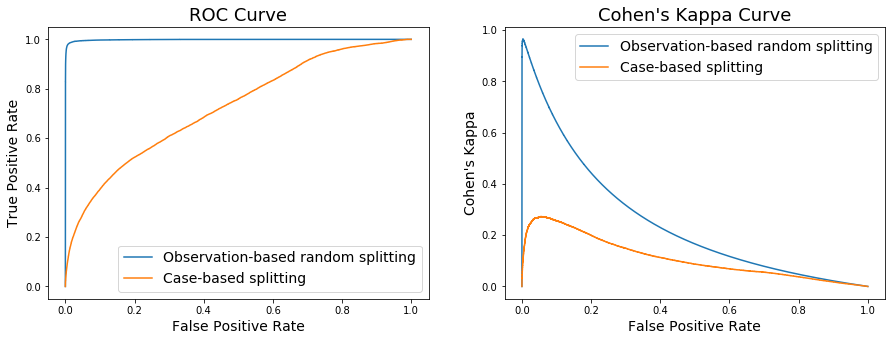

In [21]:
#ROC & Kappa curves of LGBM classifier
from sklearn.metrics import roc_curve
from modules.kappa import kappa_curve
fig, ax = plt.subplots(1,2, figsize=(15,5))

fpr_obs, tpr_obs, thres_obs = roc_curve(df_test_obs['y'], y_score_lgbmc_obs)
fpr_case, tpr_case, thres_case = roc_curve(df_test_case['y'], y_score_lgbmc_case)
ax[0].plot(fpr_obs, tpr_obs)
ax[0].plot(fpr_case, tpr_case)

ax[0].legend(['Observation-based random splitting', 'Case-based splitting'], fontsize=14);
ax[0].set_xlabel('False Positive Rate', fontsize=14)
ax[0].set_ylabel('True Positive Rate', fontsize=14)
ax[0].set_title('ROC Curve', fontsize=18)

fpr_obs, kappa_obs, thres_obs = kappa_curve(df_test_obs['y'], y_score_lgbmc_obs)
fpr_case, kappa_case, thres_case = kappa_curve(df_test_case['y'], y_score_lgbmc_case)

ax[1].plot(fpr_obs, kappa_obs)
ax[1].plot(fpr_case, kappa_case)
ax[1].legend(['Observation-based random splitting', 'Case-based splitting'], fontsize=14);
ax[1].set_xlabel('False Positive Rate', fontsize=14)
ax[1].set_ylabel("Cohen's Kappa", fontsize=14)
ax[1].set_title("Cohen's Kappa Curve", fontsize=18)

# fig.savefig(os.path.join(figs_base_path,'ROC-Kappa-splitting-strategies.png'),
#             dpi=200,
#             pad_inches=100)